In [45]:
import pandas as pd
import sqlite3
import sys
sys.path.append("..")
import seaborn as sns
color_pal = sns.color_palette()
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


color_map = pd.read_csv("../src/fpl/pipelines/model_pipeline/team_mapping.csv")
color_map = color_map.set_index("FBREF_NAME")["PRIMARY_COLOR"].to_dict()

with sqlite3.connect('../data/fpl.db') as con:
    processed_data = pd.read_sql_query('select * from "02_PROCESSED_DATA"', con)

## EDA

In [29]:
def plot_elos(team_df, x_cols, y_col, plot_type):
    fig, axes = plt.subplots(nrows=1, ncols=len(x_cols), figsize=(20, 5), sharey=True)
    if plot_type=="scatter":
        for ax, x in zip(axes, x_cols):
            sns.scatterplot(x=x, y=y_col, data=team_df, ax=ax, hue="SEASON", alpha=0.75)
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()

        fig.legend(handles, labels, loc='center right', title='SEASON')
        plt.subplots_adjust(right=0.9)

    elif plot_type=="boxplot":
        for ax, x in zip(axes, x_cols):
            copy_df = team_df[[x, y_col]].copy()
            copy_df[x] = pd.cut(copy_df[x], bins=np.arange(0,4, 0.5))
            sns.boxplot(x=x, y=y_col, data=copy_df, ax=ax)
    
    plt.show()

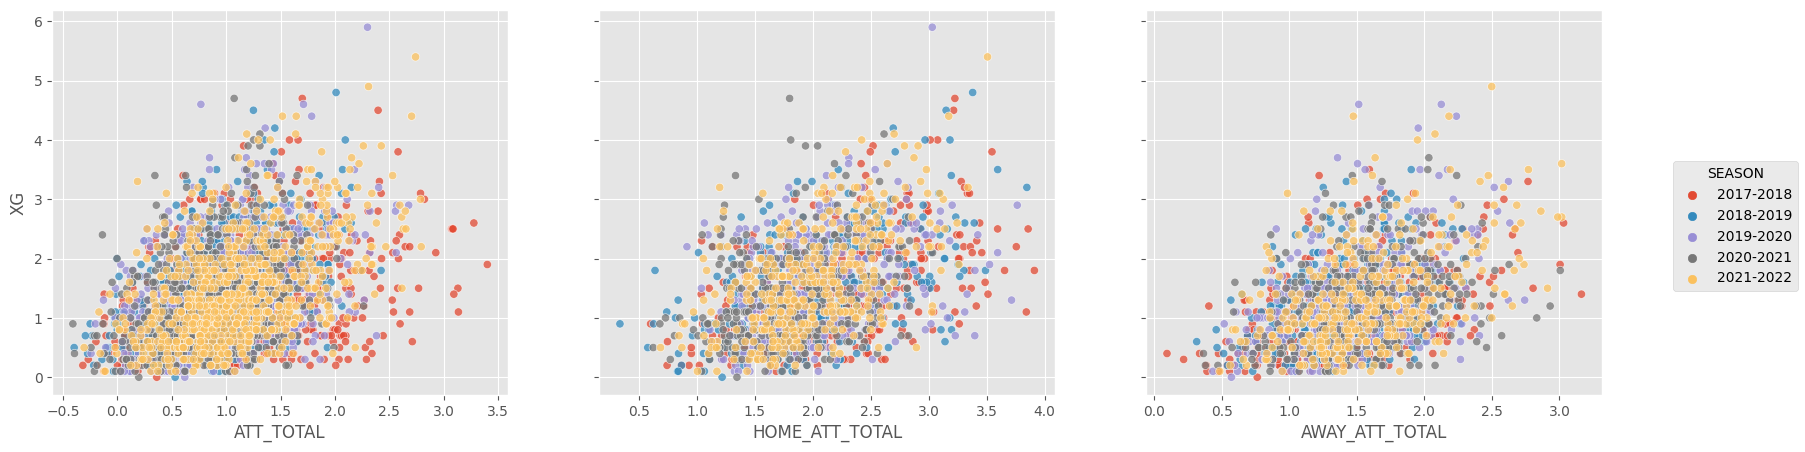

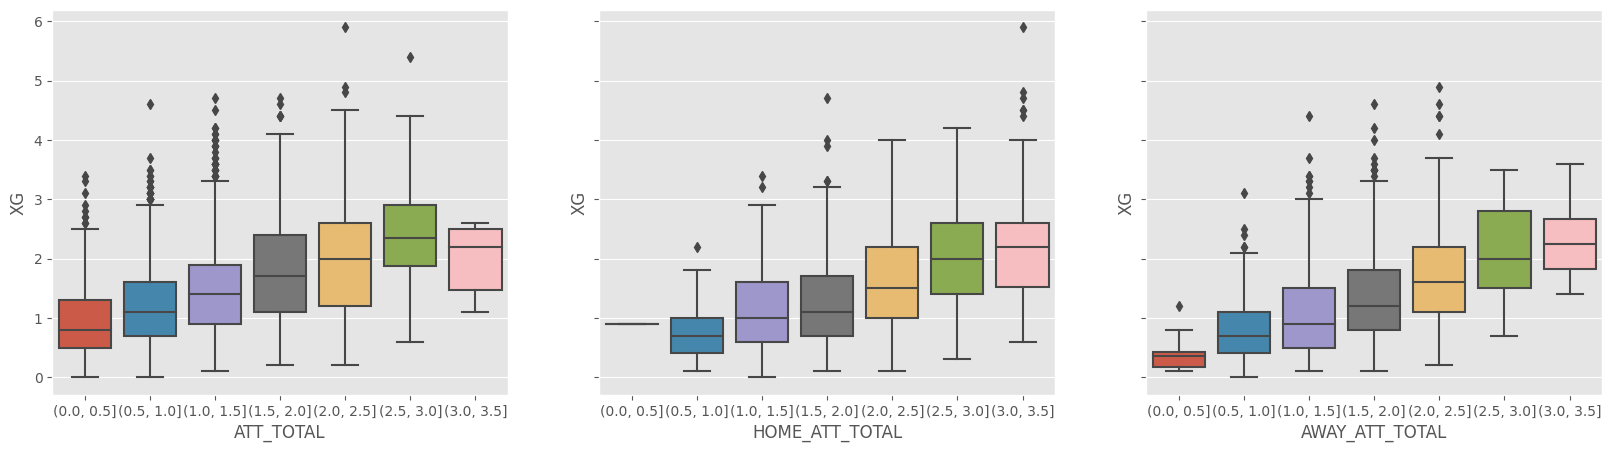

In [31]:

team_df = processed_data[processed_data["TEAM"]=="Manchester City"].copy()
plot_elos(
    processed_data, 
    ["ATT_TOTAL", "HOME_ATT_TOTAL", "AWAY_ATT_TOTAL"], 
    "XG",
    "scatter"
    )
plot_elos(
    processed_data, 
    ["ATT_TOTAL", "HOME_ATT_TOTAL", "AWAY_ATT_TOTAL"], 
    "XG",
    "boxplot"
    )

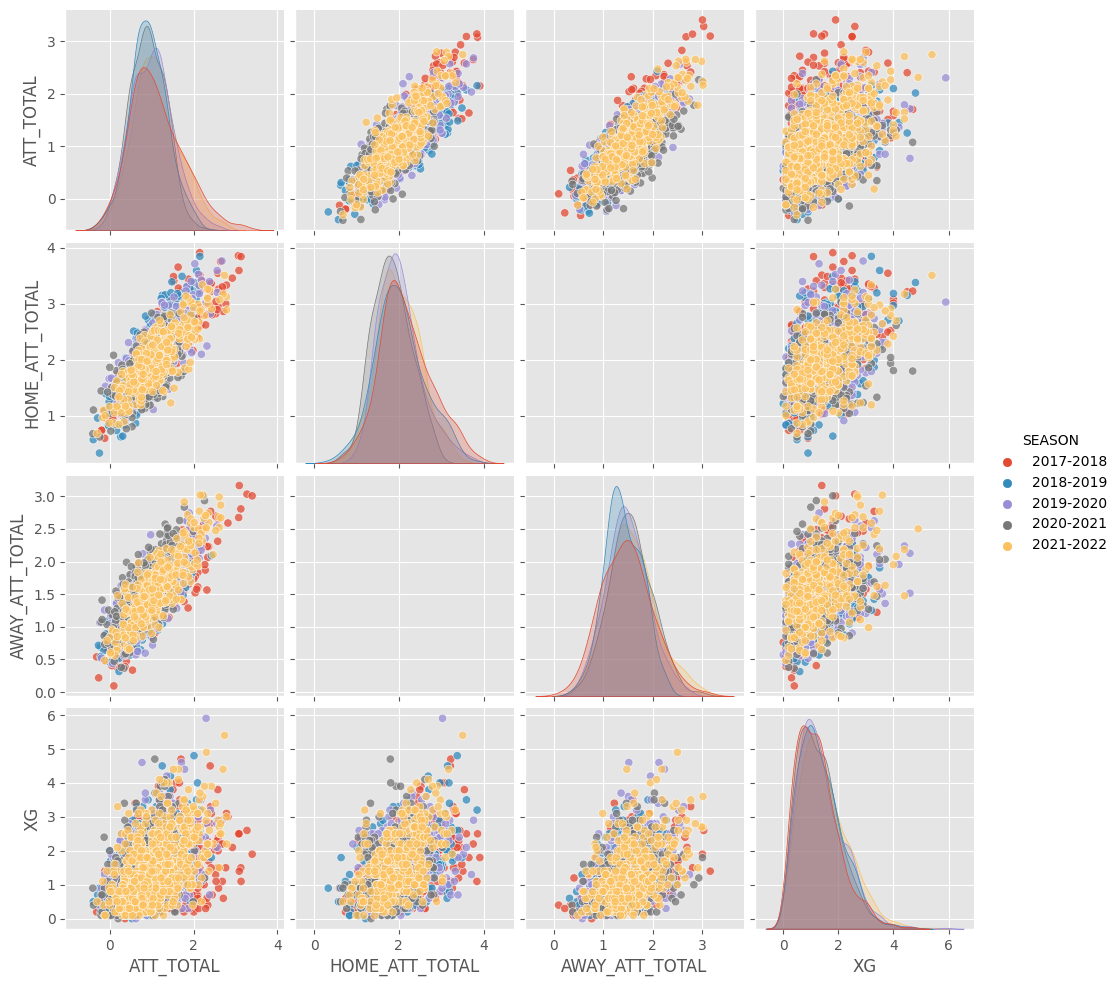

In [37]:
sns.pairplot(
    processed_data, 
    vars=["ATT_TOTAL", "HOME_ATT_TOTAL", "AWAY_ATT_TOTAL", "XG"],
    hue="SEASON",
    plot_kws={'alpha': 0.75})
plt.show()

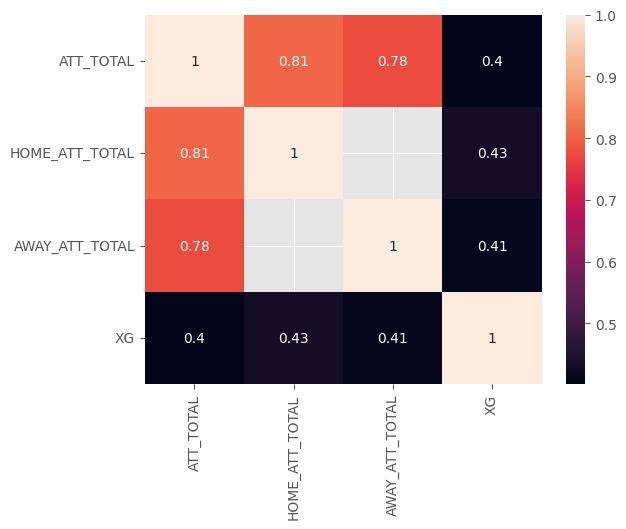

In [44]:
sns.heatmap(processed_data[["ATT_TOTAL", "HOME_ATT_TOTAL", "AWAY_ATT_TOTAL", "XG"]].corr(), annot=True)
plt.show()

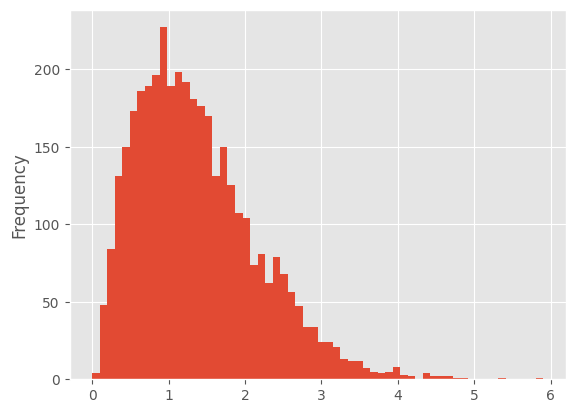

In [49]:
processed_data["XG"].plot(kind='hist', bins=60)
plt.show()

## Model creation

In [51]:
def encode_features(X, categorical_features, numerical_features, encoder):
    X_cat = X[categorical_features]
    X_num = X[numerical_features]

    X_encoded = np.hstack([
        encoder.transform(X_cat).toarray(),
        X_num
    ])
    return X_encoded

In [ ]:
numerical_features = ['ROUND', 'POSS', 'DAYS_TILL_NEXT', 'DAYS_SINCE_LAST', 'ATT_TOTAL', 'HOME_ATT_TOTAL', 'AWAY_ATT_TOTAL'] 
# 'DEF_TOTAL', 'HOME_DEF_TOTAL', 'AWAY_DEF_TOTAL', 'DATE', 'XGA', ]
categorical_features = ['VENUE', 'TEAM', 'OPPONENT']
target = "XG"

train_val_data = processed_data[processed_data['SEASON'] < "2021-2022"]
X_train_val = train_val_data[numerical_features+categorical_features]
y_train_val = train_val_data[target]

holdout_data = processed_data[processed_data['SEASON'] >= "2021-2022"]
X_holdout  = holdout_data[numerical_features+categorical_features]
y_holdout  = holdout_data[target]

In [62]:
groups = train_val_data["SEASON"]
n_splits = groups.nunique()
print(f"{groups.unique() = }")
group_kfold = GroupKFold(n_splits=n_splits)

X_train_val_cat = X_train_val[categorical_features]
categories = [np.append(X_train_val_cat[col].unique(), 'Unknown') for col in X_train_val_cat.columns]
encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', categories=categories, min_frequency=1)
encoder.fit(X_train_val_cat)
encoded_cat_cols = encoder.get_feature_names_out(input_features=categorical_features)

model = XGBRegressor(
    base_score=0.5,
    n_estimators=1000,
    early_stopping_rounds=50,
    objective ='reg:squarederror', 
    learning_rate=0.01,
    eval_metric='mae', 
    seed=42
    )

cross_val_scores = []
for train_index, val_index in group_kfold.split(X_train_val, y_train_val, groups):

    # Remove outliers
    X_train, y_train = X_train_val.iloc[train_index], y_train_val.iloc[train_index]
    outlier = y_train > 4
    X_train, y_train = X_train.loc[~outlier], y_train.loc[~outlier]

    X_train_encoded = encode_features(X_train, categorical_features, numerical_features, encoder)    
    X_val_encoded = encode_features(X_train_val.iloc[val_index], categorical_features, numerical_features, encoder)
    y_val = y_train_val.iloc[val_index]

    model.fit(
        X_train_encoded, y_train,
        eval_set=[(X_train_encoded, y_train), (X_val_encoded, y_val)],
        verbose=100
        )

    val_predictions = model.predict(X_val_encoded)
    val_accuracy = mean_squared_error(y_val, val_predictions)
    cross_val_scores.append(val_accuracy)


avg_cv_accuracy = sum(cross_val_scores) / n_splits
print(f'Average cross-validation accuracy: {avg_cv_accuracy}')
print(cross_val_scores)

groups.unique() = array(['2017-2018', '2018-2019', '2019-2020', '2020-2021'], dtype=object)
[0]	validation_0-mae:0.84848	validation_1-mae:0.83666
[100]	validation_0-mae:0.51876	validation_1-mae:0.57969
[200]	validation_0-mae:0.45042	validation_1-mae:0.55539
[293]	validation_0-mae:0.42850	validation_1-mae:0.55634
[0]	validation_0-mae:0.82986	validation_1-mae:0.90709
[100]	validation_0-mae:0.51563	validation_1-mae:0.62025
[200]	validation_0-mae:0.45334	validation_1-mae:0.58159
[296]	validation_0-mae:0.43136	validation_1-mae:0.57992
[0]	validation_0-mae:0.83460	validation_1-mae:0.88303
[100]	validation_0-mae:0.51894	validation_1-mae:0.58828
[200]	validation_0-mae:0.45594	validation_1-mae:0.54911
[266]	validation_0-mae:0.43895	validation_1-mae:0.54918
[0]	validation_0-mae:0.86094	validation_1-mae:0.79907
[100]	validation_0-mae:0.52959	validation_1-mae:0.53274
[198]	validation_0-mae:0.46486	validation_1-mae:0.52584
Average cross-validation accuracy: 0.5182467767576279
[0.5210533796878895, 0

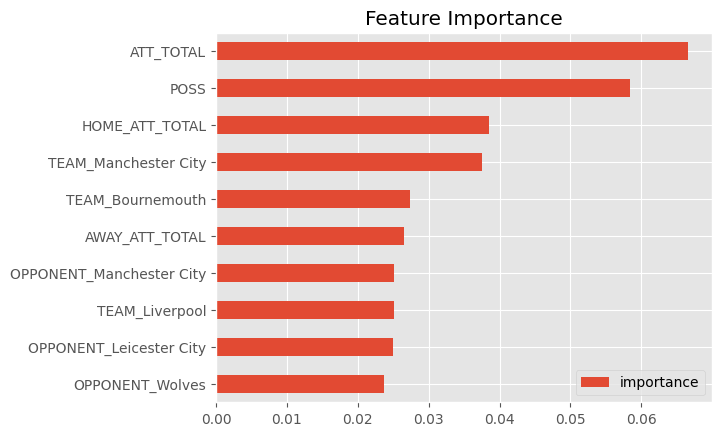

In [63]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=encoded_cat_cols.tolist()+numerical_features,
             columns=['importance'])
fi = fi.sort_values(by='importance', ascending=False).head(10)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

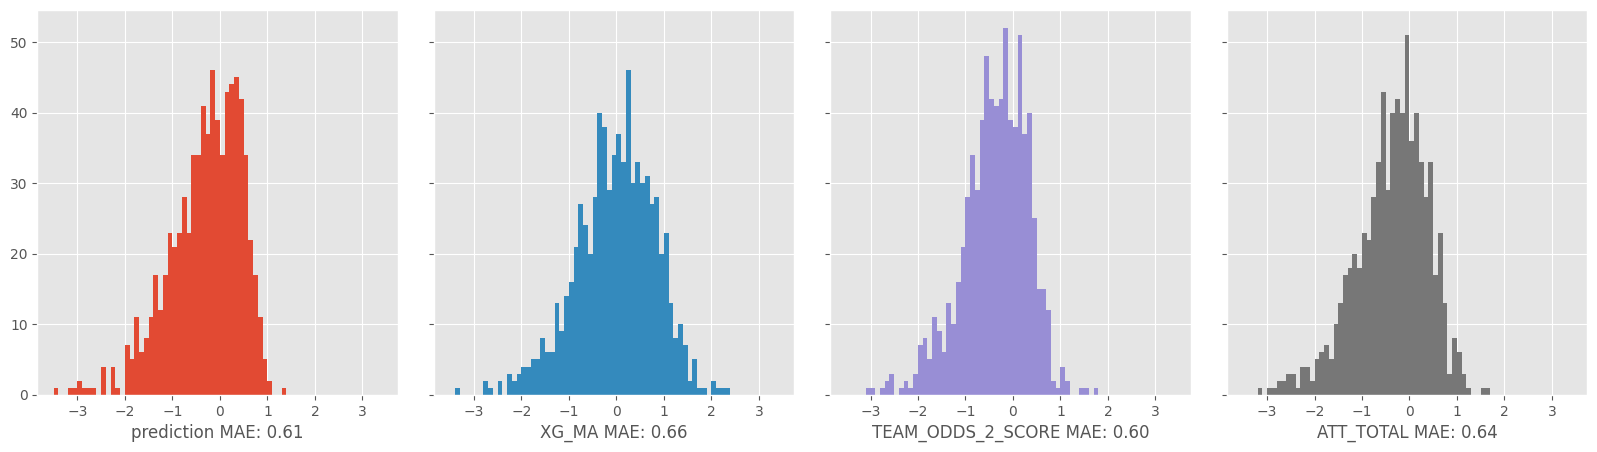

In [64]:
X_holdout_encoded = encode_features(X_holdout, categorical_features, numerical_features, encoder)
holdout_predictions = model.predict(X_holdout_encoded)


baseline_columns = ['XG_MA', "TEAM_ODDS_2_SCORE", 'ATT_TOTAL']
output_cols = list(set(["index"]+numerical_features+categorical_features+[target]+baseline_columns))
output_df = holdout_data[output_cols].copy()
eval_cols = ["prediction"]+baseline_columns
output_df["prediction"] = holdout_predictions

fig, axes = plt.subplots(nrows=1, ncols=len(eval_cols), figsize=(20, 5), sharey=True)

for i, col in enumerate(eval_cols):
    output_df[f"{col}_error"] = output_df[col] - output_df[target]
    output_df[f"{col}_error"].hist(ax=axes[i], bins=np.arange(-3.5, 3.5, 0.1), color=color_pal[i])
    mae = output_df[f"{col}_error"].abs().mean()
    axes[i].set_xlabel(f"{col} MAE: {mae:.2f}")
output_df.head()
plt.subplots_adjust(wspace=0.1)
plt.show()